# Perkenalan

Name : Destriana Ramadani <br>
Batch : RMT-028 <br>

## Background
Maternal health is an important aspect of women's health during pregnancy, childbirth, and the postpartum period. specifically, during pregnancy, different health factors like age, blood disorders, heart rate, etc. can lead to pregnancy complications. Detecting such health factors can alleviate the risk of pregnancy-related complications.

## Objective :
This project aims to identify factors that influence the health risks of pregnant women using machine learning using health data record. <br>
The main focus is to develop models that accurately predict the level of risk during pregnancy, with the main aim of minimizing identification errors and ensuring appropriate labeling of pregnant women who are potentially at high risk during pregnancy.

## Data Understanding
The maternal health risk dataset utilized in this project was
acquired from kaggle (https://www.kaggle.com/datasets/csafrit2/maternal-health-risk-data) <br>
The dataset contained six predictive variables in pregnancy and one target categoric variable of risk level :
- Age : Age in years when a woman is pregnant.
- SystolicBP : Upper value of Blood Pressure in mmHg.
- DiastolicBP : Lower value of Blood Pressure in mmHg.
- BS : Blood glucose levels is in terms of a molar concentration, mmol/L.
- HeartRate : A normal resting heart rate in beats per minute.
- RiskLevel : Predicted Risk Intensity Level during pregnancy considering the previous attribute.

# Import Libraries

In [14]:
# Import the required libraries
from sklearn.metrics import classification_report, make_scorer, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from feature_engine.outliers import Winsorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import kendalltau
from sklearn.svm import SVC


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost 
import pickle

import warnings

%matplotlib inline
warnings.filterwarnings("ignore")


# Data Loading

In [15]:
# Read files in CSV format
df = pd.read_csv('data.csv')

# Displays the number of rows and columns of the dataset
print(df.shape)

# Displays the top 10 rows in the dataset
df.head(10)

(1014, 7)


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.00,98.0,86,high risk
1,35,140,90,13.00,98.0,70,high risk
2,29,90,70,8.00,100.0,80,high risk
3,30,140,85,7.00,98.0,70,high risk
4,35,120,60,6.10,98.0,76,low risk
5,23,140,80,7.01,98.0,70,high risk
6,23,130,70,7.01,98.0,78,mid risk
7,35,85,60,11.00,102.0,86,high risk
8,32,120,90,6.90,98.0,70,mid risk
9,42,130,80,18.00,98.0,70,high risk


In [16]:
# Displays the bottom 10 rows in the dataset
df.tail(10)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
1004,13,90,65,9.0,101.0,80,high risk
1005,17,90,65,7.7,103.0,67,high risk
1006,17,85,60,6.3,102.0,86,high risk
1007,40,120,75,7.7,98.0,70,high risk
1008,48,120,80,11.0,98.0,88,high risk
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk
1013,32,120,65,6.0,101.0,76,mid risk


In [17]:
# Displays column information from a dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


> The data used in this project consists of 1014 rows and 7 columns with 6 numeric type columns which will be feature variables and 1 categorical type column which will be the target variable. It can also be seen that there are no missing values ​​in the data.

# Exploratory Data Analysis

## Univariate Analysis

### Numerical Feature

In [18]:
# Separating columns into categorical and numeric data types to make the EDA process easier
cat_col = df[['RiskLevel']].columns.tolist()
num_col = df.drop(cat_col, axis=1).columns.tolist()

# Displays the number of categorical columns and the column names
print(f'Number of Categorical Columns :{len(cat_col)}')
print(cat_col)

# Displays the number of numeric columns and their column names
print(f'Number of Numeric Columns :{len(num_col)}')
print(num_col)

Number of Categorical Columns :1
['RiskLevel']
Number of Numeric Columns :6
['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']


In [19]:
# Function to display histograms and boxplots in numeric columns and display descriptive statistical information
def data_dist(df,variables):
    norm_dist = []
    norm_dist_with_outlier =[]

    skew_dist = []
    skew_dist_with_outlier = []

    for variable in variables:
        plt.figure(figsize=(16, 4))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[variable], bins=30)
        plt.title(f'{variable}')

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[variable])
        plt.title(f'{variable}')
        plt.show()

        if df[variable].skew() > -0.5 and df[variable].skew() < 0.5:
            upper_boundary = df[variable].mean() + 3 * df[variable].std()
            lower_boundary = df[variable].mean() - 3 * df[variable].std()
            outlier = len(df[df[variable] > upper_boundary]) + len(df[df[variable] < lower_boundary])

            print(f'The {variable} column is normally distributed')
            print(f'Skewness  : {df[variable].skew()}')
            print(f'Median: {df[variable].median()}')
            print(f'Mean: {df[variable].mean()}')
            print(f'Number of Outliers : {outlier}')
            print(f'% Percentage of outliers : {(len(df[df[variable] > upper_boundary]) + len(df[df[variable] < lower_boundary])) / (len(df) * 100)}\n')
            norm_dist.append(variable)

            if outlier > 0:
                norm_dist_with_outlier.append(variable)

        else:
            iqr = df[variable].quantile(0.75) - df[variable].quantile(0.25)
            upper_boundary_skew = df[variable].quantile(0.75) + 1.5 * iqr
            lower_boundary_skew = df[variable].quantile(0.25) - 1.5 * iqr
            outlier = len(df[df[variable] > upper_boundary_skew]) + len(df[df[variable] < lower_boundary_skew])

            print(f'The {variable} column has a skew distribution')
            print(f'Skewness  : {df[variable].skew()}')
            print(f'Median: {df[variable].median()}')
            print(f'Mean: {df[variable].mean()}')
            print(f'Number of Outliers : {outlier}')
            print(f'% Percentage of outliers : {(len(df[df[variable]> upper_boundary_skew]) + len(df[df[variable]< lower_boundary_skew])) / (len(df) * 100)}\n')
            skew_dist.append(variable)

            if outlier > 0:
                skew_dist_with_outlier.append(variable)

    print(f'Variables are normally distributed :{norm_dist}')
    print(f'Variables are normally distributed with outliers :{norm_dist_with_outlier}\n')

    print(f'Variables have a skew distribution :{skew_dist}')
    print(f'Variables have a skew distribution with outliers :{skew_dist_with_outlier}\n')

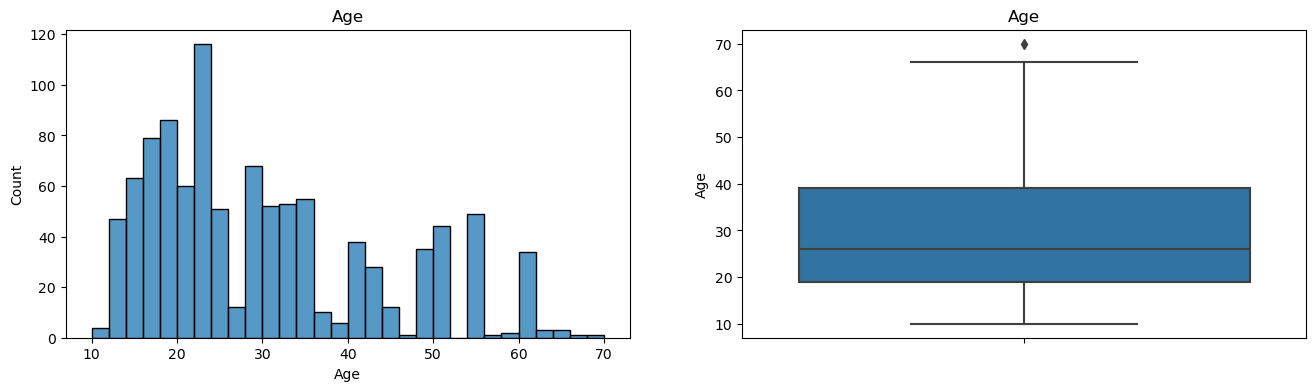

The Age column has a skew distribution
Skewness  : 0.7830634848558812
Median: 26.0
Mean: 29.871794871794872
Number of Outliers : 1
% Percentage of outliers : 9.861932938856015e-06



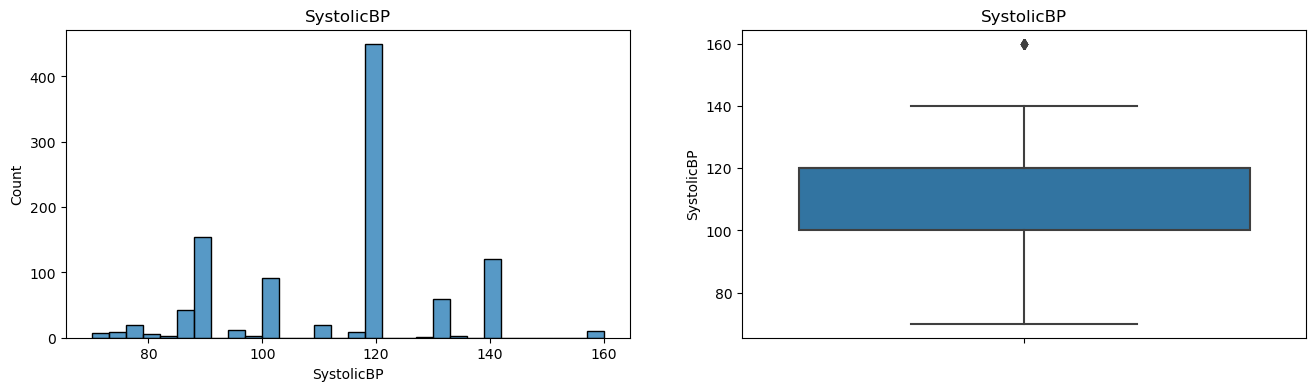

The SystolicBP column is normally distributed
Skewness  : -0.2511893119843189
Median: 120.0
Mean: 113.19822485207101
Number of Outliers : 0
% Percentage of outliers : 0.0



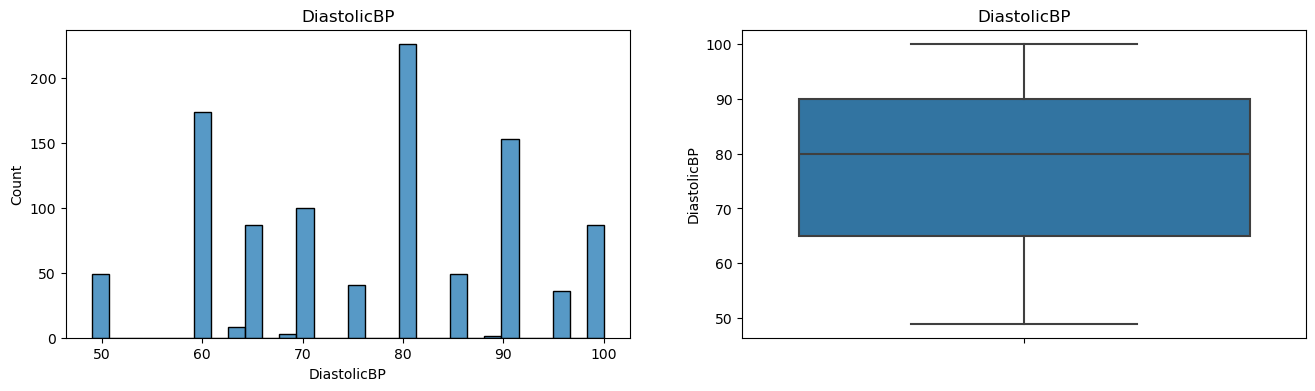

The DiastolicBP column is normally distributed
Skewness  : -0.048440762689906526
Median: 80.0
Mean: 76.46055226824457
Number of Outliers : 0
% Percentage of outliers : 0.0



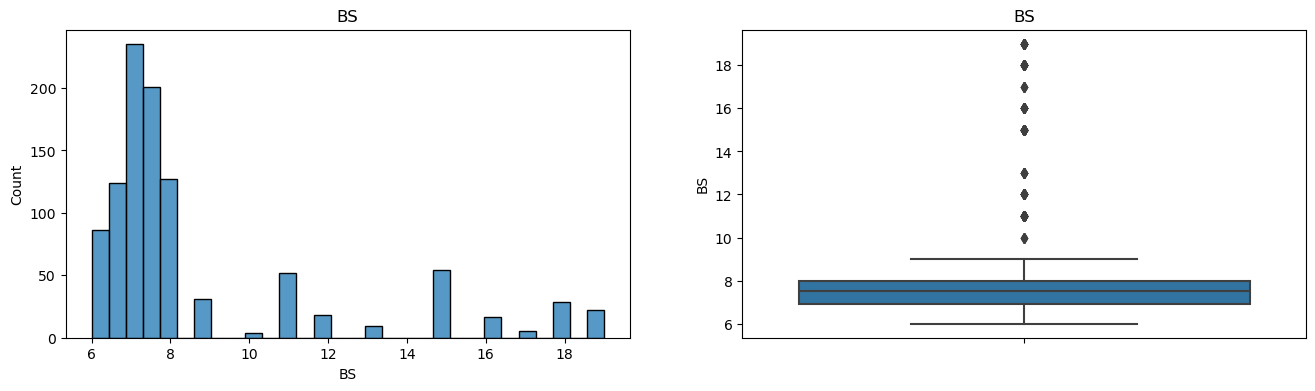

The BS column has a skew distribution
Skewness  : 1.8682026686175632
Median: 7.5
Mean: 8.725986193293886
Number of Outliers : 210
% Percentage of outliers : 0.0020710059171597634



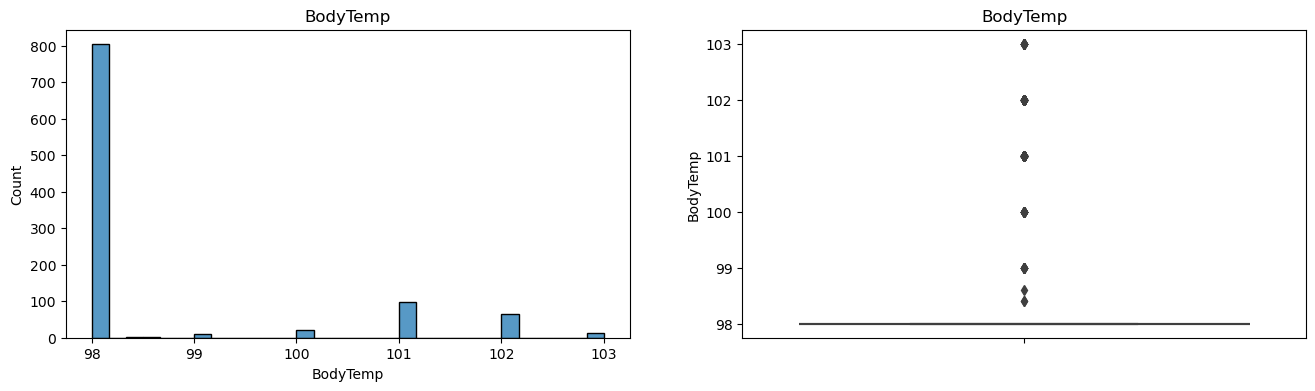

The BodyTemp column has a skew distribution
Skewness  : 1.7509884998547103
Median: 98.0
Mean: 98.66508875739645
Number of Outliers : 210
% Percentage of outliers : 0.0020710059171597634



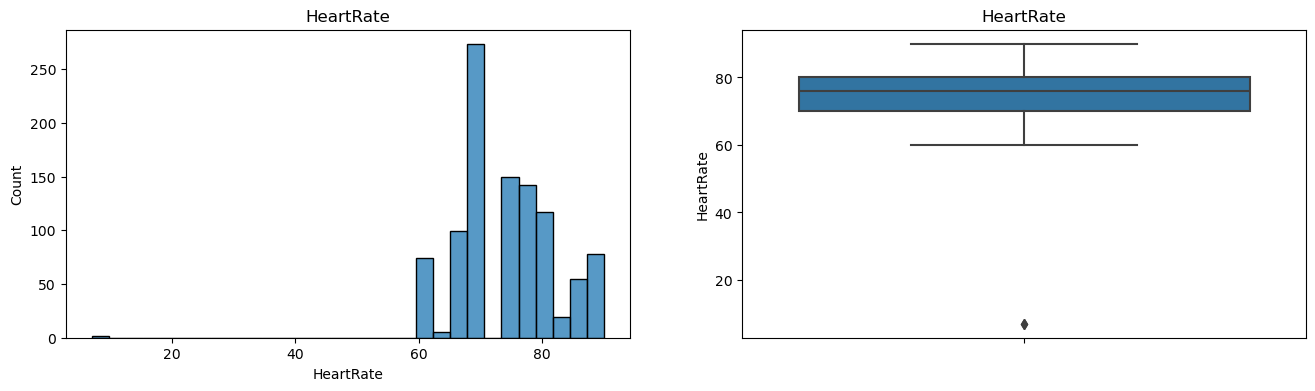

The HeartRate column has a skew distribution
Skewness  : -1.043525262063238
Median: 76.0
Mean: 74.30177514792899
Number of Outliers : 2
% Percentage of outliers : 1.972386587771203e-05

Variables are normally distributed :['SystolicBP', 'DiastolicBP']
Variables are normally distributed with outliers :[]

Variables have a skew distribution :['Age', 'BS', 'BodyTemp', 'HeartRate']
Variables have a skew distribution with outliers :['Age', 'BS', 'BodyTemp', 'HeartRate']



In [20]:
data_dist(df,num_col)

> From the graph of the numerical column visualization results, it can be seen that the 'SystolicBP' and 'DiastolicBP' columns are normally distributed and have no outliers. Meanwhile, the other columns have a skew distribution, either leaning to the left or right, and there are outliers in several columns with a skew distribution.

### Categorical Feature

In [21]:
# Function to display a barchart from categorical columns and display information on the amount of data and the proportion of unique values
def diagnostic_plots_categoric(df, variabel):
    fig, axes = plt.subplots(figsize=(12, 4))

    sns.countplot(data=df, x=variabel, palette='Set1')
    axes.set_title(f'Distribution of {variabel}')
    
    axes.set_xlabel(variabel)
    axes.set_ylabel('Count')


    plt.tight_layout()

    count = df[variabel].value_counts()
    percent = 100*df[variabel].value_counts(normalize=True)
    df_count_percent = pd.DataFrame({'Amount of data':count, 'Percentage':percent.round(1)})

    print(df_count_percent)

    plt.show()

           Amount of data  Percentage
RiskLevel                            
low risk              406        40.0
mid risk              336        33.1
high risk             272        26.8


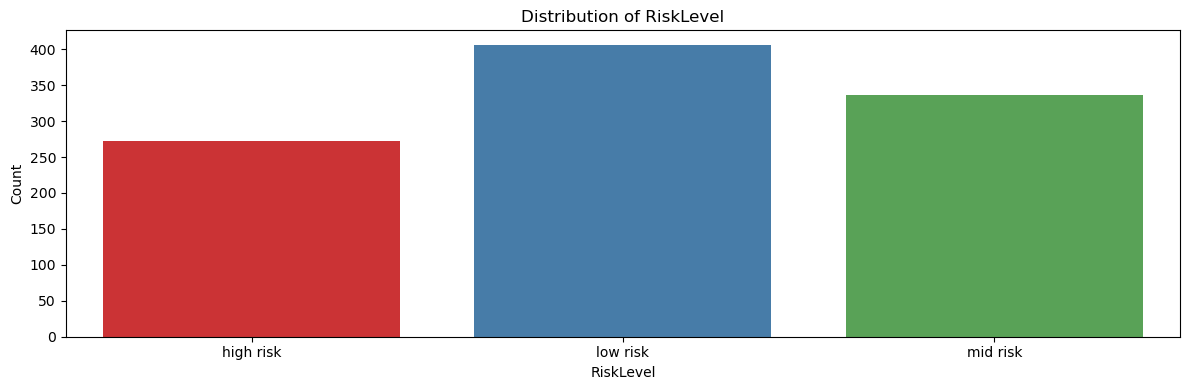

In [22]:
for col in cat_col:
    diagnostic_plots_categoric(df, col)

> From the graph of the visualization results of the categorical column as well as the target variable, it can be seen that the 'low risk' class is the class with the highest amount of data at 40%, followed by the 'mid risk' class at 33.1% and the class with the lowest amount of data is 'high risk' ' as much as 26.8%. The number of the three classes is still quite balanced because the amount of data in the minority class is more than half the amount of data in the majority class so there is no need to handle imbalance data.

## Bivariate Analysis

### Risk Level vs Numeric Feature

In [23]:
def dens_plot(col):
    # List of risk levels
    risks = ['low risk', 'mid risk', 'high risk']

    # Iterate through the risk levels
    for risk in risks:
        # Subset the DataFrame for the current risk level
        subset = df[df['RiskLevel'] == risk]

        # Plot the kernel density for the 'HeartRate' feature
        sns.distplot(subset[col], hist=False, kde=True,
                    kde_kws={'shade': True, 'linewidth': 3},
                    label=risk)

    # Add labels and legend
    plt.xlabel(f'{col}')
    plt.ylabel('Density')
    plt.title(f'Density Plot of {col} for Different Risk Levels')
    plt.legend()

    # Show the plot
    plt.show()

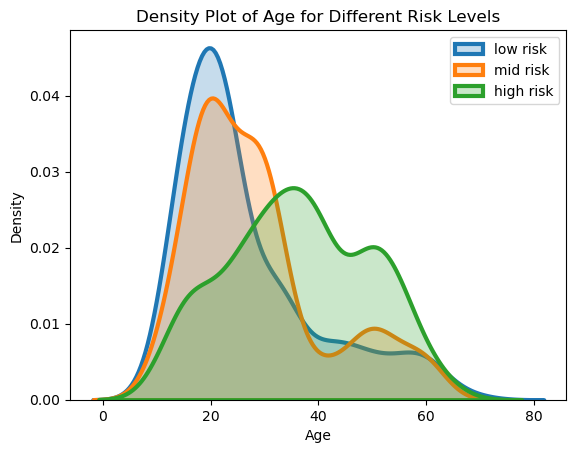

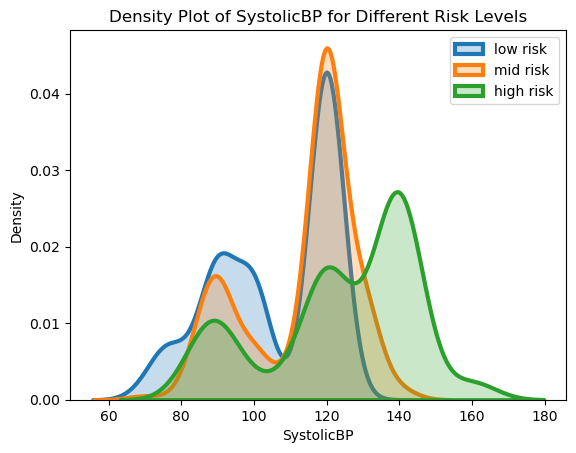

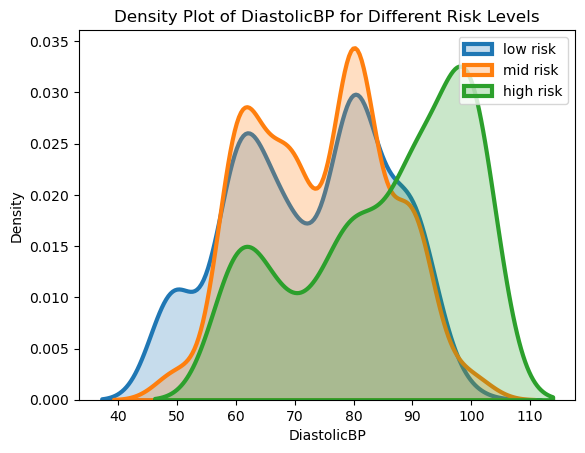

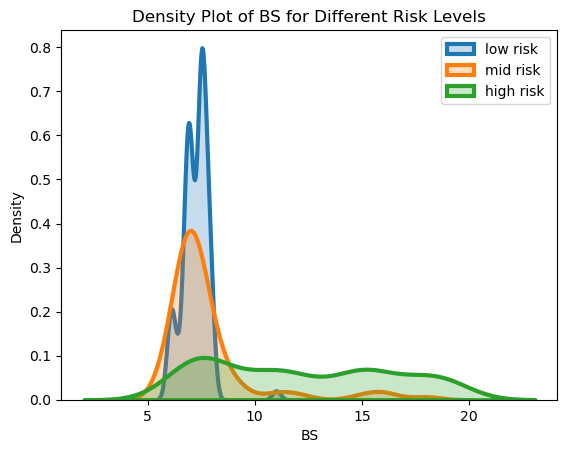

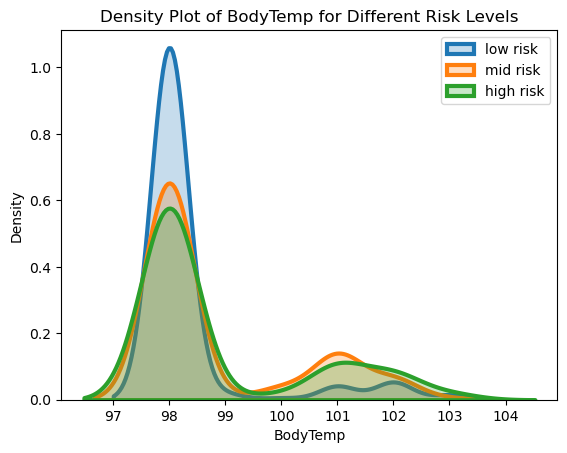

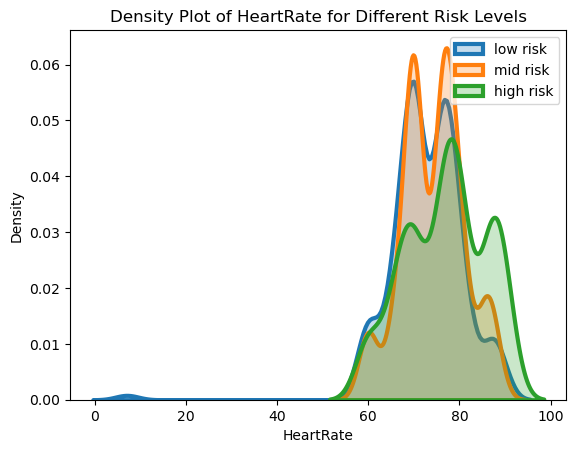

In [24]:
for col in df.drop(['RiskLevel'], axis=1).columns.tolist():
    dens_plot(col)

> From the results of the density plot of the feature variable with the target variable, the following results are obtained:
> - Probability of pregnancy risk based on age:
>   - The probability of women having a low and medium risk of pregnancy is when they are 20 years old with a higher probability of experiencing a low risk of pregnancy at that age.
>   - The probability that women have a high risk of pregnancy is when they are over 37 years old.
> - Probability of pregnancy risk based on Systolic pressure:
>   - The probability that a woman has a low and medium risk of pregnancy is when the systolic pressure is 120.
>   - The probability that a woman has a high risk of pregnancy is when the systolic pressure is more than 135 with the highest probability at a systolic pressure of 42.
> - Probability of pregnancy risk based on Diastolic pressure:
>   - The probability that a woman has a low and medium risk of pregnancy is when the diastolic pressure is 80.
>   - The probability that a woman has a high risk of pregnancy is when the diastolic pressure is 88 with the highest probability at a diastolic pressure of 100.
> - Probability of pregnancy risk based on blood sugar levels:
>   - The probability that a woman has a low and medium risk of pregnancy is when the blood sugar level is 7.
>   - The probability that a woman has a high risk of pregnancy is when the blood sugar level is more than 9.
> - Probability of pregnancy risk based on heart rate:
>   - The probability that a woman has a low and medium risk of pregnancy is when her heart rate is 70-80.
>   - The probability that a woman has a high risk of pregnancy is when the blood sugar level is more than 81 with the highest probability at a systolic pressure of 90.
> - Body temperature does not have a significant effect on the risk of pregnancy
> There are many similarities in feature characteristics between high risk and medium risk class data

# Feature Engineering

In [25]:
# Drop duplicates data
df.drop_duplicates()

# Change the label on the target variable to numeric
df['RiskLevel'].replace({'low risk':0, 'mid risk':1, 'high risk':2},inplace=True)

## Split Dataset

In [26]:
# Divide the dataframe with X being a feature variable containing columns other than 'price' and y being the 'price' column as the target variable
X = df.drop(['RiskLevel'], axis=1)
y = df['RiskLevel']

# Divide train data and test data in the proportion of 8:2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print('Train size : ', X_train.shape)
print('Test size  : ', X_test.shape)

Train size :  (811, 6)
Test size  :  (203, 6)


## Feature Selection

The feature variables used in developing this model are of the numerical type with the target variables being of the categorical type, so the Kendall Tau method will be used.<br>
Kendall Tau is a non-parametric statistical method used to measure the degree of correlation between feature variables of the numerical data type and target variables of the categorical type.

In [27]:
# Conducting numerical data correlation testing using Kendall Tau method
for col in num_col:
    corr_rho, pval_s = kendalltau(y_train, X_train[col])
    if pval_s < 0.05:
        print(f"rho-correlation {col} column: {corr_rho:.2f}, p-value: {pval_s}")

rho-correlation Age column: 0.23, p-value: 4.2994819387070624e-17
rho-correlation SystolicBP column: 0.35, p-value: 4.2195337730950415e-31
rho-correlation DiastolicBP column: 0.26, p-value: 7.601016501217537e-20
rho-correlation BS column: 0.33, p-value: 1.6152898139600582e-31
rho-correlation BodyTemp column: 0.14, p-value: 1.4060834035992467e-05
rho-correlation HeartRate column: 0.17, p-value: 3.4083016571940928e-09


> From the results of the correlation calculations that have been carried out, it can be seen that of the 7 feature variables, 6 of them have a significant correlation with the target variable, so these 6 features will be used in model training.

In [28]:
# Feature selection result column
new_col = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'HeartRate']

# Changes train, test, and validation data according to new column results feature selection
X_train = X_train[new_col]
X_test = X_test[new_col]

## Handling Outlier
From the EDA results, it is known that columns with outliers only exist in columns with a skew distribution, so an outlier handling method will be chosen that is suitable for columns with a skew distribution.

### Skew Distribution
The Winsorizer method is a statistical technique used to overcome or reduce the effects of outliers in data distribution. Outliers are values ​​that are significantly different from the majority of values ​​in a data set. Winsorizing reduces the impact of outliers by replacing outlier values ​​with less extreme values

In [29]:
# Find a column with a skew distribution
skew_dist = ['Age', 'BS', 'HeartRate']

# Applying the Winsorizer method to the distributed column of the skew
winsorizer = Winsorizer(capping_method='iqr',
                             tail='both',
                             fold=3,
                             variables=skew_dist)

X_train[skew_dist] = winsorizer.fit_transform(X_train[skew_dist])

## Handling Missing Value
Handling missing values ​​is the process of dealing with missing or incomplete values ​​in a dataset. Handling missing values ​​is very important because it can affect the quality and reliability of the machine learning model

In [30]:
# Check missing value X_train
if X_train.columns[X_train.isna().any()].tolist():
    print("The X_train column contains missing values:")
    for col in X_train.columns[X_train.isna().any()].tolist():
        print(f'{col} : {X_train[col].isna().sum()}')
else:
    print("No column on X_train with missing value")


# Check missing value X_test
if X_test.columns[X_test.isna().any()].tolist():
    print("The X_test column contains missing values:")
    for col in X_test.columns[X_test.isna().any()].tolist():
        print(f'{col} : {X_test[col].isna().sum()}')
else:
    print("No column on X_test with missing value")


# Check missing value y_train
if y_train.isna().any():
    print(f'Number of missing values on y_train: {y_train.isna().sum()}')
else:
    print("No missing value on y_train")


# Check missing value y_test
if y_test.isna().any():
    print(f'Number of missing values on y_test: {y_test.isna().sum()}')
else:
    print("No missing value on y_test")

No column on X_train with missing value
No column on X_test with missing value
No missing value on y_train
No missing value on y_test


> From the results of checking missing values, no columns were found with missing values

## Feature Scalling
Feature scaling is the process of changing feature values ​​in a dataset so that they have similar or equivalent scales. Scaling helps ensure that each feature makes a balanced contribution to model building

- Standard Scaler method is used for the scaling stage on normally distributed numerical data because this method changes the data values ​​to have a mean of 0 and a standard deviation of 1 so it is appropriate to use on normally distributed data.
- Minmax Scaler method is used for the scaling stage for numerical data with a skew distribution because this method's calculations use minimum and maximum values ​​(not mean and median) in the data so it is good for use on data that is not normally distributed.

In [31]:
# Separate normal distributed data columns with skew distributed Data for use in scaling processes
normal_feature = ['SystolicBP', 'DiastolicBP']
skew_feature = ['Age', 'BS', 'HeartRate']

In [32]:
# Define the pipeline for Standard Scaler
normal_transformer = Pipeline(
    steps=[("standscaler", StandardScaler())]
)

# Define the pipeline for Min-Max Scaler
skew_transformer = Pipeline(
    steps=[("mmscaler", MinMaxScaler()),]
)
# Define the ColumnTransformer that applies different transformers to specific feature subsets
preprocessor = ColumnTransformer(
    transformers=[
        ("normal_dist", normal_transformer, normal_feature),
        ("skew_dist", skew_transformer, skew_feature),
    ]
)

preprocessor

ColumnTransformer(transformers=[('normal_dist',
                                 Pipeline(steps=[('standscaler',
                                                  StandardScaler())]),
                                 ['SystolicBP', 'DiastolicBP']),
                                ('skew_dist',
                                 Pipeline(steps=[('mmscaler', MinMaxScaler())]),
                                 ['Age', 'BS', 'HeartRate'])])

In [33]:
# Transform the training set using the preprocessor
X_train_final = preprocessor.fit_transform(X_train)

# Transform the test set using the preprocessor
X_test_final = preprocessor.transform(X_test)

# Model Definition

- K-Nearest Neighbors (KNN):
Classification algorithm based on the principle that similar objects tend to be close to each other.
    - Advantages:
        Simple and easy to implement.
        Does not require explicit learning.
    - Disadvantages:
        Susceptible to outliers.
        Performance may be affected by high dimensions.

- Support Vector Machine (SVM):
SVM looks for the best decision boundary (hyperplane) that separates two classes in feature space.
    - Advantages:
        Effective in high-dimensional feature spaces.
        Suitable for classification and regression problems.
    - Disadvantages:
        Susceptible to overfitting if parameters are not set properly.
        The performance can decrease with very large datasets.

- Decision Tree:
Decision tree builds a decision tree based on a series of hierarchical decisions. Each node in the tree represents a decision based on a particular feature.
    - Advantages:
        Easy to interpret and can be visualized.
        Does not require complicated data preprocessing.
    - Disadvantages:
        Susceptible to overfitting, especially on deep trees.
        Sensitive to small changes in data.

- Random Forest:
Random Forest is ensemble learning consisting of a large number of decision trees. Each tree is generated randomly and independently, and the results are combined for a final prediction.
    - Advantages:
        Overcoming the common overfitting problem in decision trees.
        Able to handle large datasets with high-dimensional features.
    - Disadvantages:
        Difficult to interpret compared to a single decision tree.
        Requires more computing resources.

- XGBoost:
XGBoost is an ensemble algorithm that uses a boosting approach.
Combining a large number of weak models (weak learners) to create a strong model.
    - Advantages:
        High performance and good accuracy.
        Can handle various data types and problems.
    - Disadvantages:
        Susceptible to overfitting if parameters are not set properly.
        Requires more computing resources.

<b>Because the main focus is to label pregnant women who are potentially at high risk and medium risk during pregnancy (reducing FN) so the matrix used is recall</b>

In [34]:
# Define the K-Nearest Neighbors (KNN) Classifier
knn = KNeighborsClassifier()

# Define the Support Vector Machine (SVM) Classifier with a random state
svm = SVC(random_state=111)

# Define the Decision Tree Classifier with a random state
dt = DecisionTreeClassifier(random_state=111)

# Define the Random Fores Classifier with a random state
rf = RandomForestClassifier(random_state=111)

# Define the XGBoost Classifier with a random state
xgb = xgboost.XGBClassifier(random_state=111)

# Model Training

In [35]:
# Create a custom scoring function for recall with weighted averaging
recall_scorer = make_scorer(recall_score, average='weighted')

## Model Training : K Neighbors Classifier (KNN)

In [36]:
scores_knn = cross_val_score(knn, X_train_final, y_train, cv=5, scoring=recall_scorer)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_knn.mean(), scores_knn.std()))

0.68 accuracy with a standard deviation of 0.03


## Model Training : Support Vector Machines (SVM)

In [37]:
scores_svm = cross_val_score(svm, X_train_final, y_train, cv=5, scoring=recall_scorer)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_svm.mean(), scores_svm.std()))

0.65 accuracy with a standard deviation of 0.03


## Model Training : Decision Tree

In [38]:
scores_dt = cross_val_score(dt, X_train_final, y_train, cv=5, scoring=recall_scorer)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_dt.mean(), scores_dt.std()))

0.80 accuracy with a standard deviation of 0.03


## Model Training : Random Forest

In [39]:
scores_rf = cross_val_score(rf, X_train_final, y_train, cv=5, scoring = recall_scorer)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_rf.mean(), scores_rf.std()))

0.81 accuracy with a standard deviation of 0.02


## Model Training : XGBoost

### Model Training : Hyperparameter Tuning XGBoost

In [40]:
scores_xgb = cross_val_score(xgb, X_train_final, y_train, cv=5, scoring=recall_scorer)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_xgb.mean(), scores_xgb.std()))

0.80 accuracy with a standard deviation of 0.02


> From the training results of the five models, it can be seen that the Random Forest models have the best accuracy.

## Model Training : Hyperparameter Tuning

### Hyperparameter Tuning : Random Forest

In [41]:
# Random Forest model parameter value candidate
rf_clf = RandomForestClassifier(random_state=111)
param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
}
# Create the pipeline with RandomForestClassifier
rf_pipe = Pipeline([('rf', rf_clf)])

# Find the best parameter value with the grid search method
rf_grid_search = GridSearchCV(estimator=rf_pipe, param_grid=param_grid, cv=5)
rf_grid_search.fit(X_train_final, y_train)

print('Best cross-validation accuracy : {:.2f}'.format(rf_grid_search.best_score_))
print('Best parameters : ', rf_grid_search.best_params_)
print('Test set accuracy : {:.2f}'.format(rf_grid_search.score(X_test_final, y_test)))

Best cross-validation accuracy : 0.81
Best parameters :  {'rf__max_depth': 20, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}
Test set accuracy : 0.86


> The baseline Random Forest model yielded a cross-validation score of 0.81, while after hyperparameter tuning, the testing accuracy of the Random Forest model increased to 0.87

# Model Evaluation

## Model Evaluation : Random Forest

Random Forest Train  : 
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       316
           1       0.92      0.89      0.90       282
           2       0.95      0.93      0.94       213

    accuracy                           0.92       811
   macro avg       0.93      0.92      0.92       811
weighted avg       0.92      0.92      0.92       811



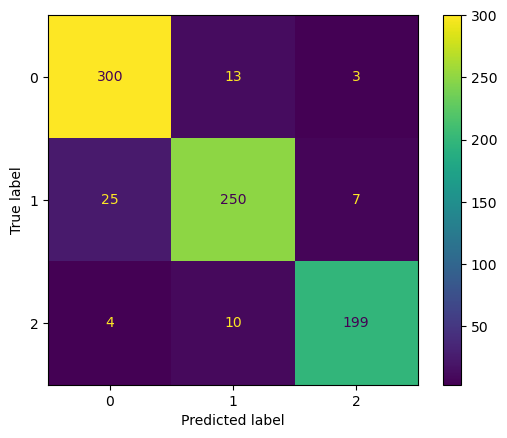

Random Forest Test   : 
              precision    recall  f1-score   support

           0       0.86      0.87      0.86        76
           1       0.83      0.80      0.81        65
           2       0.90      0.92      0.91        62

    accuracy                           0.86       203
   macro avg       0.86      0.86      0.86       203
weighted avg       0.86      0.86      0.86       203



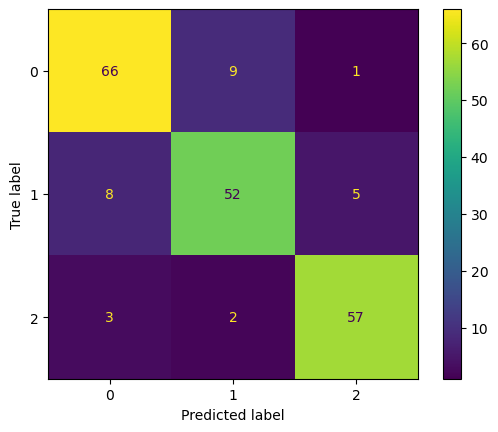

In [42]:
# Predictions using the Random Forest model
y_pred_train_rf = rf_grid_search.predict(X_train_final)
y_pred_test_rf = rf_grid_search.predict(X_test_final)

# Random Forest model evaluation results
print('Random Forest Train  : ')
print(classification_report(y_pred_train_rf, y_train))
cm = confusion_matrix(y_pred_train_rf, y_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

print('Random Forest Test   : ')
print(classification_report(y_pred_test_rf, y_test))
cm = confusion_matrix(y_pred_test_rf, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

> From the model evaluation, the train recall score were 0.93 for the high risk class predictions and 0.89 for the medium risk class predictions, while the test recall score were 0.92 for the high risk class predictions and 0.80 for the medium risk class predictions. These results indicate that the model is better at predicting the high risk class compared to medium risk. This can be seen from the quite large difference in the recall score between the medium risk class train data predictions and the medium risk class test data predictions.

# Model Saving

In [43]:
# create a combined preprocess pipeline with the best model
best_estimator = rf_grid_search.best_estimator_
final_model=Pipeline([('preprocess',preprocessor),('model',best_estimator)])
final_model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('normal_dist',
                                                  Pipeline(steps=[('standscaler',
                                                                   StandardScaler())]),
                                                  ['SystolicBP',
                                                   'DiastolicBP']),
                                                 ('skew_dist',
                                                  Pipeline(steps=[('mmscaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'BS',
                                                   'HeartRate'])])),
                ('model',
                 Pipeline(steps=[('rf',
                                  RandomForestClassifier(max_depth=20,
                                                         max_features='auto',
                                                         n_estimators=50,
                                                         random_state=111))]))])

In [44]:
# saves functions to .pkl format
with open('final_model.pkl', 'wb') as file_1:
  pickle.dump(final_model, file_1)

# Conceptual Problem
1. Jelaskan latar belakang adanya bagging dan cara kerja bagging !
> Bagging (Bootstrap Aggregating) is an ensemble learning technique designed to improve the performance and stability of machine learning models. The background to bagging is related to two main problems in model building:
> - Variability (Variance):
Models that are complex or prone to overfitting can have high variability, that is, be sensitive to small fluctuations in the training data. This can result in good performance on training data but poor performance on test data.
> - Overfitting:
Overfitting occurs when a model understands too much detail and noise in the training data, so it is less able to generalize well to data it has never seen before<br>
> How Bagging Works:<br>
> Bagging works by taking multiple bootstrap samples (sampling with replacement) from the training dataset and training the model on each bootstrap sample. Then, the prediction results from each model are integrated to produce the final prediction.

2. Jelaskan perbedaan cara kerja algoritma Random Forest dengan algoritma boosting yang Anda pilih !
> - Ensemble Approach:
>   - Random Forest uses a bagging approach, where the trees are built independently.
>   - XGBoost uses a boosting approach, where trees are built sequentially to correct previous model errors.
> - Emphasis on Mistakes:
>   - XGBoost places more emphasis on samples that are difficult to predict through the use of weights.
>   - Random Forest uses randomization in feature selection to increase variation between trees.
> - Regularization:
>   - XGBoost uses regularization to control model complexity and prevent overfitting.
>   - Random Forest relies on variation between trees to reduce overfitting.

3. Jelaskan apa yang dimaksud dengan Cross Validation !
> Cross-validation is a technique used in machine learning to measure model performance by dividing data into different subsets and evaluating the model on these subsets. The goal is to get a better estimate of the model's performance on data it has not yet seen. Cross-validation helps produce more reliable estimates of model performance, especially when the dataset is limited. This helps minimize the risk of a model learning that is too specific to one particular subset of data and improves the model's generalization to data it has never seen before.

# Conclusion

> The results of the EDA obtained the following results:
> Age, systolic and diastolic blood pressure, blood glucose levels, and heart rate are factors that significantly influence the risk during pregnancy. The higher these factors, the greater the probability that women are at a high risk during pregnancy. Meanwhile, body temperature does not affect the risk of pregnancy. In the density plot, it is observed that the density of the medium-risk class exhibits similar fluctuations to the high-risk class.

> The results of the model evaluation from the test data obtained the following results:<br>
> The model successfully predicted 92% of the data in the high-risk class. However, it could only predict 80% of the data in the medium-risk class. This might be attributed to the similarities in the feature characteristics between the medium-risk class and the high-risk class.

## Advice and Improvement
Before planning to have a child, it is advisable to align with the mother's age. The optimal reproductive age is between 20-35 years. Regular health examinations and monitoring before pregnancy are also crucial for detecting potential issues. Maintaining a balanced diet and monitoring blood glucose, blood pressure, and heart rate are mandatory during pregnancy.

In future research, alternative methods can be employed in addition to the ones already utilized. Clustering methods can also be applied to this data without using the existing target variable to obtain a more optimal number of classes.